In [3]:
import os
import shutil
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Flatten, BatchNormalization, Dropout, Dense
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import cv2
import bcolz
from keras.models import load_model
import random

Using TensorFlow backend.


In [6]:
path = '/home/ubuntu/hands/HandRecognition'
lr = 1e-7
opt = Adam(lr=lr)
batch_size = 64

In [7]:
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())
def flip(x):
    ''' To be used as a preprocessing function'''
    return cv2.flip(x,0)

def positive(x):
    ''' To be used as a preprocessing function'''
    return 256 - x

def positive_and_flip(x):
    ''' To be used as a preprocessing function'''
    return flip(positive(x))

def crop_11k(x):
    m = x.shape[0]
    if x.shape[1] > x.shape[0]:
        m = x.shape[1]
    return x[0:m,0:m]

def crop_11k_positive_and_flip(x):
    ''' To be used as a preprocessing function'''
    return flip(positive(crop_11k(x)))

def train_valid_split(src_dirs, dest_dir = path + '/data'):
    """ This function takes a src directory and a destination directory then divides the data in the src diretory into\
    a training set and a validation set. The directory structure underneath src_dir is expected to be a directory per\
    label (i.e. '<src dir>/dogs/, <src dir>/cats/. Each label-specified subdirectory should contain the images) """
    tr = 0
    val = 0
    if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)
    if not os.path.exists(dest_dir + '/train'):
        os.mkdir(dest_dir + '/train')
    if not os.path.exists(dest_dir + '/valid'):
        os.mkdir(dest_dir + '/valid')

    for src_dir in src_dirs:
        label = src_dir.split('/')[-1]
        if not os.path.exists(dest_dir + '/train/' + label):
            os.mkdir(dest_dir + '/train/' + label)
        if not os.path.exists(dest_dir + '/valid/' + label):
            os.mkdir(dest_dir + '/valid/' + label)
        filenames = os.listdir(src_dir)
        train, valid = train_test_split(filenames, train_size=.8, test_size=.2)
        for filename in train:
            tr = tr + 1
            if os.path.exists(dest_dir + '/train/' + label + '/' + filename):
                name, ext = filename.split('.')
                shutil.copyfile(src_dir + '/' + filename, dest_dir + '/train/' + label + '/' + name + str(random.randint(0,1000)) + ext)                
            else:
                shutil.copyfile(src_dir + '/' + filename, dest_dir + '/train/' + label + '/' + filename)
        for filename in valid:
            val = val + 1
            if os.path.exists(dest_dir + '/valid/' + label + '/' + filename):
                name, ext = filename.split('.')
                shutil.copyfile(src_dir + '/' + filename, dest_dir + '/valid/' + label + '/' + name + str(random.randint(0,1000)) + ext)                
            else:
                shutil.copyfile(src_dir + '/' + filename, dest_dir + '/valid/' + label + '/' + filename)
    print("training set size : " + str(tr))
    print("valid set size    : " + str(val))
    
def flip_11k_hands():
    ig=imageDataGenerator(preprocessing_function=positive_and_flip)
    trn_batches = ig.flow_from_directory(path + '/data/train', shuffle=False, class_mode='categorical', batch_size=batch_size, target_size=(224, 224))


In [464]:
igt = ImageDataGenerator()
t_batches = igt.flow_from_directory(path + '/data/11kHands', 
                                     shuffle=True, 
                                     class_mode='categorical', 
                                     batch_size=batch_size, 
                                     target_size=(224, 224))

Found 11076 images belonging to 1 classes.


In [469]:
imgs,label = pp_batches.next()

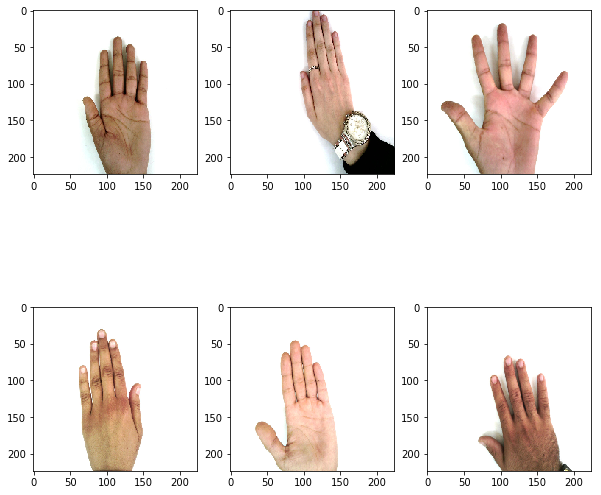

In [473]:
f, axarr = plt.subplots(2,3, figsize=(10,10))
axarr[0,0].imshow(imgs[0])
axarr[0,1].imshow(imgs[1])
axarr[0,2].imshow(imgs[2])
axarr[1,0].imshow(imgs[3])
axarr[1,1].imshow(imgs[4])
axarr[1,2].imshow(imgs[5])

In [8]:
ig=ImageDataGenerator(preprocessing_function=crop_11k_positive_and_flip)
pp_batches = ig.flow_from_directory(path + '/data/11kHands', 
                                     shuffle=True, 
                                     class_mode='categorical', 
                                     batch_size=batch_size, 
                                     target_size=(224, 224),
                                     save_to_dir= path + '/data/11kHands_224_224/Hands')
#count = 0
#while (True):
#    img, label = pp_batches.next()
#    count = count + 1
#    print("batch " + str(count))


Found 11076 images belonging to 1 classes.


In [285]:
train_valid_split([path + '/data/jj/Hands', path + '/data/aa/Hands', path + '/data/dropbox/Hands', path + '/data/ess/Hands', path + '/data/11kHands/Hands'])
#train_valid_split([path + '/data/11kHands/Hands'])

training set size : 8860
valid set size    : 2216


In [286]:
train_valid_split([path + '/data/jj//No_hands', path + '/data/aa/No_hands', path + '/data/dropbox/No_hands'])

training set size : 14023
valid set size    : 3507


In [128]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(250,200,3))

In [129]:
for layer in model.layers:
    layer.trainable=False

In [131]:
x = model.layers[-1].output
x = Flatten(input_shape=model.output_shape[1:])(x)
x = BatchNormalization()(x)
x = Dropout(0)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0)(x)
x = Dense(2, activation='softmax')(x)
model1 = Model(input=model.input,output=x)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Softmax.0, inputs=/input_1)`


In [349]:
ig = ImageDataGenerator(horizontal_flip=True, rotation_range=20, shear_range=3.14, zoom_range=.1,preprocessing_function=vgg_preprocess)
ig2 = ImageDataGenerator(preprocessing_function=vgg_preprocess)
val_batches = ig2.flow_from_directory(path + '/data/valid', shuffle=False, class_mode='categorical', batch_size=batch_size, target_size=(224, 224))
trn_batches = ig.flow_from_directory(path + '/data/train', shuffle=False, class_mode='categorical', batch_size=batch_size, target_size=(224, 224))

val_classes = val_batches.classes
trn_classes = trn_batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

Found 5656 images belonging to 2 classes.
Found 21732 images belonging to 2 classes.


In [197]:
intermediate_layer_model = Model(model.input, model.get_layer('block5_pool').output)

NameError: name 'model' is not defined

In [12]:
trn_conv_out = intermediate_layer_model.predict_generator(trn_batches,trn_batches.samples // batch_size + 1, verbose=1)
val_conv_out = intermediate_layer_model.predict_generator(val_batches,val_batches.samples // batch_size + 1, verbose=1)

NameError: name 'intermediate_layer_model' is not defined

In [5]:
from keras import regularizers
fc_model = Sequential([
    Flatten(input_shape=model.output_shape[1:]),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

NameError: name 'model' is not defined

In [286]:
trn_conv_out = load_array(path + '/train_lastlayer_features.bc')
val_conv_out = load_array(path + '/val_lastlayer_features.bc')

IOError: [Errno 2] No such file or directory: '/home/ubuntu/hands/HandRecognition/train_lastlayer_features.bc/meta/sizes'

In [12]:
fc_model.load_weights('fc_weights.hd5')

In [378]:
from keras.optimizers import SGD, RMSprop
lr = 1e-4
opt = Adam(lr=lr)
fc_model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [358]:
#fc_model.fit(trn_conv_out, trn_labels, steps_per_epoch=trn_batches.samples // batch_size, nb_epoch=2, validation_data=(val_conv_out,val_labels), shuffle=True)

In [379]:
fc_model.fit(trn_conv_out, trn_labels, nb_epoch=32, batch_size=64, validation_data=(val_conv_out, val_labels), shuffle=True)

Train on 19290 samples, validate on 5209 samples
Epoch 1/32
19290/19290 [==============================] - 4s 202us/step - loss: 0.0950 - acc: 0.9651 - val_loss: 0.0078 - val_acc: 0.9969
Epoch 2/32
19290/19290 [==============================] - 4s 195us/step - loss: 0.0141 - acc: 0.9956 - val_loss: 0.0043 - val_acc: 0.9981
Epoch 3/32
19290/19290 [==============================] - 4s 197us/step - loss: 0.0080 - acc: 0.9976 - val_loss: 0.0031 - val_acc: 0.9992
Epoch 4/32
18944/19290 [============================>.] - ETA: 0s - loss: 0.0051 - acc: 0.9987

KeyboardInterrupt: 

In [19]:
val_batches = ig.flow_from_directory(path + '/data/valid', shuffle=True, class_mode='categorical', batch_size=batch_size, target_size=(250,200))

Found 2257 images belonging to 2 classes.


In [66]:
test_batches = ig.flow_from_directory(path + '/data/kps_hands', shuffle=True, class_mode='categorical', batch_size=batch_size, target_size=(200,250))

Found 326 images belonging to 2 classes.


In [15]:
val_batches.shuffle = True

In [360]:
imgs, labels = _batches.next()

In [24]:
from keras import backend as K
K.clear_session()

In [387]:
final_model = Sequential()
final_model.add(model)
final_model.add(fc_model)
final_model.compile(Adam(lr=.00001), 'categorical_crossentropy', ['accuracy'])
for layer in model.layers:
    layer.trainable=False

In [34]:
final_model.save_weights('final_model.hd5')

In [393]:
final_model.save('model.hd5')

In [355]:
imgs, labels = val_batches.next()

In [359]:
pred_probs = final_model.predict(imgs)

pred_labels = [(1,0) if p[0] > p[1] else (0,1) for p in pred_probs]

Populating the interactive namespace from numpy and matplotlib


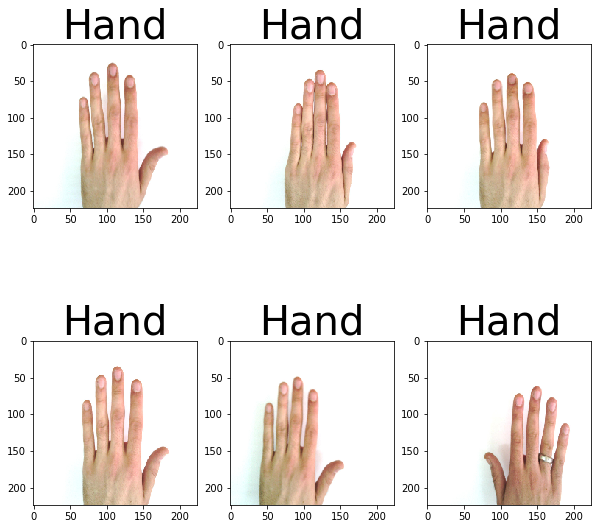

In [360]:
%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline

#plt.imshow(imgs[0], cmap='gray')

f, axarr = plt.subplots(2,3, figsize=(10,10))
axarr[0,0].set_title("Hand" if pred_labels[0][0] == 1 else "No Hand", fontsize=40)
axarr[0,0].imshow(imgs[0])
axarr[0,1].set_title("Hand" if pred_labels[1][0] == 1 else "No Hand", fontsize=40)
axarr[0,1].imshow(imgs[1])
axarr[0,2].set_title("Hand" if pred_labels[2][0] == 1 else "No Hand", fontsize=40)
axarr[0,2].imshow(imgs[2])
axarr[1,0].set_title("Hand" if pred_labels[3][0] == 1 else "No Hand", fontsize=40)
axarr[1,0].imshow(imgs[3])
axarr[1,1].set_title("Hand" if pred_labels[4][0] == 1 else "No Hand", fontsize=40)
axarr[1,1].imshow(imgs[4])
axarr[1,2].set_title("Hand" if pred_labels[5][0] == 1 else "No Hand", fontsize=40)
axarr[1,2].imshow(imgs[5])

In [ ]:
cv2.imshow('image',imgs[0])

In [18]:
fc_model.save_weights('fc_weights.hd5')

In [21]:
save_array(path + '/train_lastlayer_features.bc', trn_conv_out)
save_array(path + '/val_lastlayer_features.bc', val_conv_out)

In [7]:
model = load_model('model.hd5')

In [38]:
ig = ImageDataGenerator()
val_batches = ig.flow_from_directory(path + '/data/kps_hands', shuffle=True, class_mode='categorical', batch_size=8, target_size=(224,224))

Found 326 images belonging to 2 classes.


In [44]:
imgs, labels = val_batches.next()

In [217]:
1

1

In [294]:
imgs, _ = trn_batches.next()

In [295]:
imgs.shape

(128, 256, 256, 3)

In [307]:
1

1

In [308]:
from keras.layers import Input, Conv2D, MaxPooling2D
simple_conv_model = Sequential([
        BatchNormalization(input_shape=(240,320,3)),
        Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(.1)),
        MaxPooling2D(pool_size=(3,3)),
        BatchNormalization(),
        Dropout(0.5),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(.1)),
        MaxPooling2D(pool_size=(3,3)),
        BatchNormalization(),
        Dropout(0.5),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(.1)),
        MaxPooling2D(pool_size=(3,3)),
        BatchNormalization(),
        Dropout(0.5),
        Flatten(),
        Dense(2, activation='softmax')
])

In [309]:
from keras.callbacks import ModelCheckpoint

lr = 1e-3
opt = Adam(lr=lr)
batch_size=128
filepath="11k-weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
simple_conv_model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
simple_conv_model.fit_generator(trn_batches, steps_per_epoch=trn_batches.samples // batch_size, nb_epoch=10, validation_data=val_batches, validation_steps=val_batches.samples // batch_size, shuffle=True,callbacks=callbacks_list)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., shuffle=True, validation_data=<keras.pre..., steps_per_epoch=169, epochs=10, callbacks=[<keras.ca..., validation_steps=44)`


Epoch 1/10
168/169 [============================>.] - ETA: 9s - loss: 3.6527 - acc: 0.8574 
Epoch 00001: val_acc improved from -inf to 0.68359, saving model to 11k-weights-improvement-01-0.68.hdf5
169/169 [==============================] - 1869s 11s/step - loss: 3.6386 - acc: 0.8581 - val_loss: 1.6774 - val_acc: 0.6836
Epoch 2/10
 38/169 [=====>........................] - ETA: 21:42 - loss: 1.1873 - acc: 0.9369

KeyboardInterrupt: 

In [413]:
simple_conv_model.save('simple_conv_model.hd5')

In [31]:
val_batches.reset()

In [371]:
val_batches.shuffle =  True

In [36]:
imgs, labels = val_batches.next()
pred_probs = simple_conv_model.predict_proba(imgs)

pred_labels = [(1,0) if p[0] > p[1] else (0,1) for p in pred_probs]

Populating the interactive namespace from numpy and matplotlib


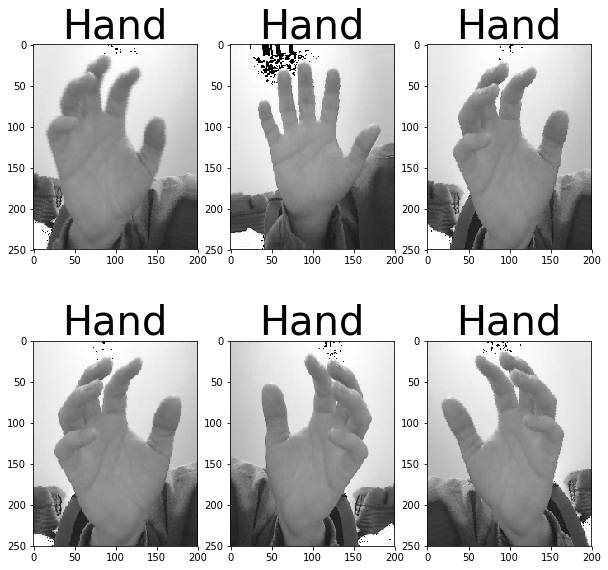

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline

#plt.imshow(imgs[0], cmap='gray')

f, axarr = plt.subplots(2,3, figsize=(10,10))
axarr[0,0].set_title("Hand" if pred_labels[0][0] == 1 else "No Hand", fontsize=40)
axarr[0,0].imshow(255 - imgs[0])
axarr[0,1].set_title("Hand" if pred_labels[1][0] == 1 else "No Hand", fontsize=40)
axarr[0,1].imshow(255 - imgs[1])
axarr[0,2].set_title("Hand" if pred_labels[2][0] == 1 else "No Hand", fontsize=40)
axarr[0,2].imshow(255 - imgs[2])
axarr[1,0].set_title("Hand" if pred_labels[3][0] == 1 else "No Hand", fontsize=40)
axarr[1,0].imshow(255 - imgs[3])
axarr[1,1].set_title("Hand" if pred_labels[4][0] == 1 else "No Hand", fontsize=40)
axarr[1,1].imshow(255 - imgs[4])
axarr[1,2].set_title("Hand" if pred_labels[5][0] == 1 else "No Hand", fontsize=40)
axarr[1,2].imshow(255 - imgs[5])

In [160]:
labels[0:6]

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]], dtype=float32)

In [158]:
val_batches.filenames

['Hands/Hand_0000007.jpg',
 'Hands/Hand_0000011.jpg',
 'Hands/Hand_0000013.jpg',
 'Hands/Hand_0000015.jpg',
 'Hands/Hand_0000022.jpg',
 'Hands/Hand_0000023.jpg',
 'Hands/Hand_0000032.jpg',
 'Hands/Hand_0000040.jpg',
 'Hands/Hand_0000048.jpg',
 'Hands/Hand_0000067.jpg',
 'Hands/Hand_0000069.jpg',
 'Hands/Hand_0000077.jpg',
 'Hands/Hand_0000081.jpg',
 'Hands/Hand_0000083.jpg',
 'Hands/Hand_0000087.jpg',
 'Hands/Hand_0000094.jpg',
 'Hands/Hand_0000095.jpg',
 'Hands/Hand_0000101.jpg',
 'Hands/Hand_0000102.jpg',
 'Hands/Hand_0000107.jpg',
 'Hands/Hand_0000114.jpg',
 'Hands/Hand_0000116.jpg',
 'Hands/Hand_0000133.jpg',
 'Hands/Hand_0000143.jpg',
 'Hands/Hand_0000158.jpg',
 'Hands/Hand_0000160.jpg',
 'Hands/Hand_0000166.jpg',
 'Hands/Hand_0000176.jpg',
 'Hands/Hand_0000178.jpg',
 'Hands/Hand_0000180.jpg',
 'Hands/Hand_0000185.jpg',
 'Hands/Hand_0000216.jpg',
 'Hands/Hand_0000218.jpg',
 'Hands/Hand_0000224.jpg',
 'Hands/Hand_0000225.jpg',
 'Hands/Hand_0000228.jpg',
 'Hands/Hand_0000230.jpg',
 

In [345]:
from keras import backend as K
mobile_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [346]:
mobile_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [332]:
intermediate_layer_model = Model(mobile_model.input, mobile_model.get_layer('conv_pw_13_relu').output)

In [334]:
ig = ImageDataGenerator(horizontal_flip=True, rotation_range=20, shear_range=3.14, zoom_range=.1)
val_batches = ig.flow_from_directory(path + '/data/valid', shuffle=False, class_mode='categorical', batch_size=batch_size, target_size=(224, 224))
trn_batches = ig.flow_from_directory(path + '/data/train', shuffle=False, class_mode='categorical', batch_size=batch_size, target_size=(224, 224))

val_classes = val_batches.classes
trn_classes = trn_batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

Found 5656 images belonging to 2 classes.
Found 21732 images belonging to 2 classes.


In [ ]:
trn_conv_out = mobile_model.predict_generator(trn_batches,trn_batches.samples // batch_size + 1, verbose=1)
val_conv_out = mobile_model.predict_generator(val_batches,val_batches.samples // batch_size + 1, verbose=1)

45/45 [==============================] - 738s 16s/step


In [351]:
1

1

In [352]:
from keras import regularizers
fc_model = Sequential([
    Flatten(input_shape=mobile_model.output_shape[1:]),
    BatchNormalization(),
#    Dropout(0.5),
#    Dense(8, activation='relu'),
#    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

In [353]:
lr = 1e-4
opt = Adam(lr=lr)
fc_model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
fc_model.fit(trn_conv_out, trn_labels, nb_epoch=32, batch_size=64, validation_data=(val_conv_out, val_labels), shuffle=True)

Train on 21732 samples, validate on 5656 samples
Epoch 1/32
21732/21732 [==============================] - 40s 2ms/step - loss: 0.0120 - acc: 0.9954 - val_loss: 9.9618e-06 - val_acc: 1.0000
Epoch 2/32
 7616/21732 [=========>....................] - ETA: 19s - loss: 6.1252e-04 - acc: 0.9996

KeyboardInterrupt: 

In [354]:
final_model = Sequential()
final_model.add(mobile_model)
final_model.add(fc_model)
final_model.compile(Adam(lr=.00001), 'categorical_crossentropy', ['accuracy'])
for layer in mobile_model.layers:
    layer.trainable=False
final_model.save('mobile_model.hd5')

In [158]:
test_batches = ig.flow_from_directory(path + '/data/test', shuffle=False, class_mode='categorical', batch_size=batch_size, target_size=(224, 224))

Found 119 images belonging to 2 classes.


In [386]:
ig3 = ImageDataGenerator(preprocessing_function=positive)
jj_batches = ig3.flow_from_directory(path + '/data/ess/', 
                                    shuffle=True, 
                                    class_mode='categorical', 
                                    batch_size=batch_size, 
                                    target_size=(224, 224))
trn_batches = ig3.flow_from_directory(path + '/data/jj_test/', 
                                    shuffle=True, 
                                    class_mode='categorical', 
                                    batch_size=batch_size, 
                                    target_size=(224, 224))
jj_classes = trn_batches.classes
jj_labels = onehot(trn_classes)


Found 187 images belonging to 1 classes.
Found 308 images belonging to 2 classes.


In [387]:
imgs, labels = jj_batches.next()

In [389]:
jj_batches.filenames

['Hands/frame_ess_xxx_1.jpg',
 'Hands/frame_ess_xxx_10.jpg',
 'Hands/frame_ess_xxx_11.jpg',
 'Hands/frame_ess_xxx_12.jpg',
 'Hands/frame_ess_xxx_13.jpg',
 'Hands/frame_ess_xxx_14.jpg',
 'Hands/frame_ess_xxx_15.jpg',
 'Hands/frame_ess_xxx_16.jpg',
 'Hands/frame_ess_xxx_17.jpg',
 'Hands/frame_ess_xxx_18.jpg',
 'Hands/frame_ess_xxx_19.jpg',
 'Hands/frame_ess_xxx_2.jpg',
 'Hands/frame_ess_xxx_20.jpg',
 'Hands/frame_ess_xxx_21.jpg',
 'Hands/frame_ess_xxx_22.jpg',
 'Hands/frame_ess_xxx_23.jpg',
 'Hands/frame_ess_xxx_24.jpg',
 'Hands/frame_ess_xxx_25.jpg',
 'Hands/frame_ess_xxx_26.jpg',
 'Hands/frame_ess_xxx_27.jpg',
 'Hands/frame_ess_xxx_28.jpg',
 'Hands/frame_ess_xxx_29.jpg',
 'Hands/frame_ess_xxx_3.jpg',
 'Hands/frame_ess_xxx_30.jpg',
 'Hands/frame_ess_xxx_31.jpg',
 'Hands/frame_ess_xxx_32.jpg',
 'Hands/frame_ess_xxx_33.jpg',
 'Hands/frame_ess_xxx_34.jpg',
 'Hands/frame_ess_xxx_35.jpg',
 'Hands/frame_ess_xxx_36.jpg',
 'Hands/frame_ess_xxx_37.jpg',
 'Hands/frame_ess_xxx_38.jpg',
 'Hands/fra

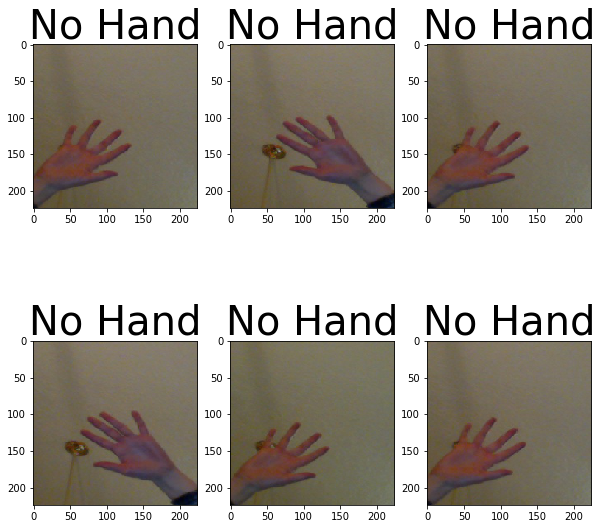

In [388]:
pred_probs = final_model.predict(imgs)
pred_labels = [(1,0) if p[0] > p[1] else (0,1) for p in pred_probs]
f, axarr = plt.subplots(2,3, figsize=(10,10))
axarr[0,0].set_title("Hand" if pred_labels[0][0] == 1 else "No Hand", fontsize=40)
axarr[0,0].imshow(imgs[0])
axarr[0,1].set_title("Hand" if pred_labels[1][0] == 1 else "No Hand", fontsize=40)
axarr[0,1].imshow(imgs[1])
axarr[0,2].set_title("Hand" if pred_labels[2][0] == 1 else "No Hand", fontsize=40)
axarr[0,2].imshow(imgs[2])
axarr[1,0].set_title("Hand" if pred_labels[3][0] == 1 else "No Hand", fontsize=40)
axarr[1,0].imshow(imgs[3])
axarr[1,1].set_title("Hand" if pred_labels[4][0] == 1 else "No Hand", fontsize=40)
axarr[1,1].imshow(imgs[4])
axarr[1,2].set_title("Hand" if pred_labels[5][0] == 1 else "No Hand", fontsize=40)
axarr[1,2].imshow(imgs[5])

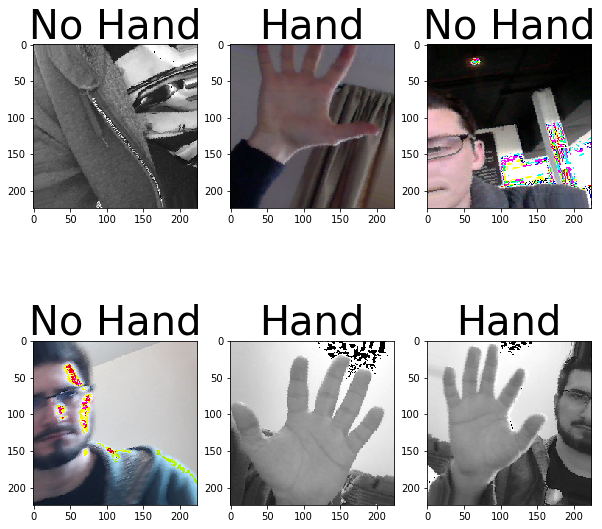

In [188]:
pred_probs = final_model.predict(imgs)
pred_labels = [(1,0) if p[0] > p[1] else (0,1) for p in pred_probs]
f, axarr = plt.subplots(2,3, figsize=(10,10))
axarr[0,0].set_title("Hand" if pred_labels[0][0] == 1 else "No Hand", fontsize=40)
axarr[0,0].imshow(255 - imgs[0])
axarr[0,1].set_title("Hand" if pred_labels[1][0] == 1 else "No Hand", fontsize=40)
axarr[0,1].imshow(255 - imgs[1])
axarr[0,2].set_title("Hand" if pred_labels[2][0] == 1 else "No Hand", fontsize=40)
axarr[0,2].imshow(255 - imgs[2])
axarr[1,0].set_title("Hand" if pred_labels[3][0] == 1 else "No Hand", fontsize=40)
axarr[1,0].imshow(255 - imgs[3])
axarr[1,1].set_title("Hand" if pred_labels[4][0] == 1 else "No Hand", fontsize=40)
axarr[1,1].imshow(255 - imgs[4])
axarr[1,2].set_title("Hand" if pred_labels[5][0] == 1 else "No Hand", fontsize=40)
axarr[1,2].imshow(255 - imgs[5])